In [25]:
import torch
from gensim.models import Word2Vec
import torch.nn as nn
import cv2
from matplotlib.pyplot import imshow
import numpy as np
import torch.nn.functional as F 

In [26]:
w2v = Word2Vec.load("bare_minimum")
w2v.wv["bear"].shape

(16,)

In [27]:
w2v.wv.__len__()

10

In [28]:
bear = cv2.imread("bear.jpg")
bear = cv2.resize(bear,(128,128))
hospital = cv2.imread("hos.png")
hospital = cv2.resize(hospital,(128,128))
hospital[100:,:,:] = 255
strike = cv2.imread("strike.jpg")
strike = cv2.resize(strike,(128,128))
imgs = np.array([(i.reshape(1,128,128,3) / 256).astype(np.float32) for i in [bear, hospital, strike]])

In [29]:
# MAKE SURE YOU ADD ANY LAYERS TO THE FORWARD FUNCTION
# THE GOAL IS COLOR
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 128, bias=False)
        self.dense2 = nn.Linear(128,768,bias=False)
        # Try upscaling more linearly, but make sure it is a square number that can be upscaled by 2 to 128
        
        self.upsample1 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv12 = nn.Conv2d(3,3,5,padding=2, bias=False)
        self.upsample2 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv22 = nn.Conv2d(3,3,5,padding=2, bias=False)
        self.upsample3 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3,3,3,padding=1, bias=False)
        self.conv32 = nn.Conv2d(3,3,5,padding=2, bias=False)
        # Try modifying the in/out channels and kernel sizes here. 
        # Can also add normal Conv layers between these, just make sure padding = kernel_size // 2
        
        self.mesh = nn.Conv2d(6, 3, 3, padding=1, bias=False)
        # Try adding additional layers here, since this is the place where
        # the current sentence image is merged with the word
        # NEW: Skip connection layers to merge low- and high-level features
        self.skip1 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after first upsample
        self.skip2 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after second upsample
        self.skip3 = nn.Conv2d(3, 3, 1, bias=False)  # Merges features after third upsample

        # NEW: Edge enhancement layers to reduce blur
        self.sharp1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.sharp2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
    def forward(self, word_vec, simage):
        
        x = self.dense1(word_vec)
        x = nn.functional.relu(x)
        
        x = self.dense2(x)
        x = nn.functional.relu(x)
        
        x = x.reshape((-1,3,16,16))
        
        x = self.upsample1(x)
        x = self.sharp1(x) 
        x = nn.functional.relu(x)
        skip_x1 = self.skip1(x)  # NEW: Capture details
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv12(x)
        x = nn.functional.relu(x)

        x = self.upsample2(x)
        x = self.sharp2(x) 
        x = nn.functional.relu(x)
        skip_x2 = self.skip2(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv22(x)
        x = nn.functional.relu(x)

        x = self.upsample3(x)
        x = nn.functional.relu(x) # <- This activation function should result in something image-like, relu isn't great
        skip_x3 = self.skip3(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv32(x)
        x = nn.functional.relu(x)

        # Make modifications here too
        # Upsample skip_x1 and skip_x2 to match x's dimensions
        skip_x1_resized = F.interpolate(skip_x1, size=x.shape[2:], mode="bilinear", align_corners=True)
        skip_x2_resized = F.interpolate(skip_x2, size=x.shape[2:], mode="bilinear", align_corners=True)

        # Merge the resized skip connections with x
        x = x + skip_x1_resized + skip_x2_resized + skip_x3
        
        x = torch.concat((simage, x), dim=1)
        return self.mesh(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1, bias=False)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1, bias=False)
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(266,128, bias=False)
        self.classify2 = nn.Linear(128,64, bias=False)
        self.classify3 = nn.Linear(64, 10, bias=False)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1, bias=False)
        self.next2 = nn.Conv2d(16,16,3,padding=1, bias=False)
        self.next3 = nn.Conv2d(16, 3, 1, bias=False)
        
        
    def forward(self, input, context):
        
        x = self.conv1(input)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.relu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.relu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.relu(c)

        c = self.flatten(c)
        c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.relu(c)
        c = self.classify2(c)
        c = nn.functional.relu(c)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = nn.functional.relu(n)
        n = self.next2(n)
        n = nn.functional.relu(n)
        n = self.next3(n)
        n = nn.functional.sigmoid(n)
        
        return c, n

In [30]:
torch.manual_seed(42)
import torch.nn.init as init

enc = Encoder()
dec = Decoder()

s = nn.ModuleList([enc,dec])

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        init.xavier_uniform_(m.weight)
        
s.apply(weights_init)

ModuleList(
  (0): Encoder(
    (dense1): Linear(in_features=16, out_features=128, bias=False)
    (dense2): Linear(in_features=128, out_features=768, bias=False)
    (upsample1): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv12): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (upsample2): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv22): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (upsample3): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv32): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=F

In [31]:
a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128) + 1)
dec(a, torch.zeros(1,10))

(tensor([[-0.0041, -0.0004,  0.0078,  0.0098, -0.0050,  0.0081, -0.0003,  0.0027,
          -0.0100,  0.0151]], grad_fn=<MmBackward0>),
 tensor([[[[0.5025, 0.5041, 0.5164,  ..., 0.5040, 0.5080, 0.5008],
           [0.4860, 0.5196, 0.5367,  ..., 0.5182, 0.5125, 0.5079],
           [0.5020, 0.5207, 0.5390,  ..., 0.5306, 0.5245, 0.5148],
           ...,
           [0.5110, 0.4974, 0.5284,  ..., 0.5157, 0.5231, 0.5210],
           [0.5052, 0.4912, 0.5162,  ..., 0.5010, 0.5213, 0.5230],
           [0.4955, 0.4837, 0.4948,  ..., 0.4867, 0.4886, 0.4990]],
 
          [[0.5073, 0.5161, 0.5294,  ..., 0.5052, 0.5081, 0.5037],
           [0.5036, 0.5031, 0.5320,  ..., 0.5252, 0.5196, 0.5077],
           [0.4985, 0.5185, 0.5393,  ..., 0.5410, 0.5263, 0.5121],
           ...,
           [0.4975, 0.5071, 0.5241,  ..., 0.5209, 0.5212, 0.5140],
           [0.4869, 0.5036, 0.5086,  ..., 0.5032, 0.5152, 0.5207],
           [0.4906, 0.4955, 0.4932,  ..., 0.4662, 0.4727, 0.4842]],
 
          [[0.5044, 0.

In [32]:
sentences = [["the", "bear", "is", "eating", "honey"],
             ["where", "is", "the", "hospital"],
             ["students", "are", "striking"]]
images = torch.tensor(imgs).permute(0,1,4,2,3)

In [33]:
images.shape

torch.Size([3, 1, 3, 128, 128])

In [34]:
# define optim
crit_words = nn.CrossEntropyLoss()
crit_image = nn.MSELoss()
optim = torch.optim.Adam(s.parameters())

In [35]:
losses = []
epochs = 1000
for epoch in range(epochs):
    sents = []
    optim.zero_grad()
    loss = torch.tensor(0)
    for img,sent in zip(images,sentences):
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        pic = canvas.clone()
        # Try modifying weights or training scheme
        loss = loss + crit_image(img, canvas)
    losses.append(loss)
    loss.backward()
    optim.step()

In [36]:
## Training loop
epochs = 250
for epoch in range(epochs):
    sents = []
    for img,sent in zip(images,sentences):
        optim.zero_grad()
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        # Try modifying weights or training scheme
        loss = crit_image(img, canvas)
        pic = canvas.clone()
        context = torch.zeros(1,10)
        outs = []
        for w in sent:
            word, canvas = dec(canvas, context)
            context = word
            loss = loss + crit_words(word, torch.tensor([w2v.wv.key_to_index[w]]))
            outs.append(word)
        loss.backward()
        optim.step()
        sents.append(outs)

In [37]:
[[w2v.wv.index_to_key[w.argmax()] for w in sen] for sen in sents]

[['the', 'bear', 'is', 'eating', 'honey'],
 ['where', 'is', 'the', 'hospital'],
 ['students', 'are', 'striking']]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24636194..1.150064].


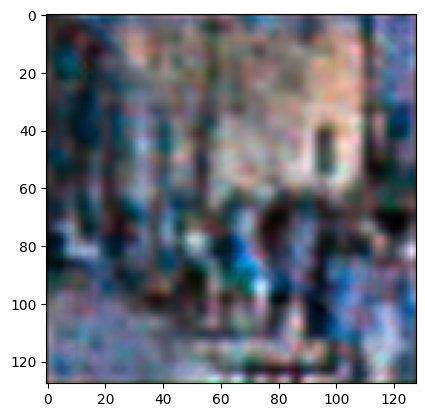

In [38]:
test = pic.squeeze()
test = test.permute(1,2,0).detach().numpy()
imshow(test)

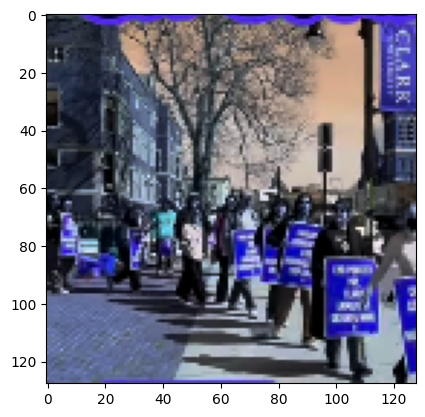

In [15]:
imshow(strike)